In [2]:
from google.cloud import bigquery
import os
import pandas as pd

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../gcp_credentials.json'
client = bigquery.Client()

In [3]:
query = """
WITH events AS (
  SELECT
    project_id,
    from_source_id,
    DATE(TIMESTAMP_TRUNC(time, MONTH)) AS bucket_month,
    event_type,
    to_name,
    from_name,
    amount
  FROM `opensource-observer.oso.int_events_to_project`
  WHERE
    from_type = 'GIT_USER'
    AND DATE(time) >= DATE_SUB(CURRENT_DATE(), INTERVAL 6 MONTH)
  )

  SELECT
    e.project_id,
    p.project_name,
    e.from_source_id,
    e.from_name,
    e.bucket_month,
    e.event_type,
    e.to_name,
    SUM(e.amount) AS contributions
  FROM events AS e
  JOIN `opensource-observer.oso.projects` AS p ON e.project_id = p.project_id
  GROUP BY
    e.project_id,
    p.project_name,
    e.from_source_id,
    e.from_name,
    e.bucket_month,
    e.event_type,
    e.to_name
"""
result = client.query(query)

In [4]:
data = result.to_dataframe()

In [5]:
df = (
    data[data['event_type'] == 'PULL_REQUEST_MERGED']
    .groupby(['project_name', 'from_name'])
    ['contributions']
    .sum()
    .reset_index()
    .groupby('project_name')
    .agg(
        num_contributors=pd.NamedAgg(column='from_name', aggfunc='nunique'),
        all_contributions=pd.NamedAgg(column='contributions', aggfunc='sum'),
        contributions_by_top_contributor=pd.NamedAgg(column='contributions', aggfunc='max')
    )
)
df['bus_factor'] = df['contributions_by_top_contributor'] / df['all_contributions']
df

,num_contributors,all_contributions,contributions_by_top_contributor,bus_factor
project_name,,,,
.NET SDK + Unity Demo by Nethereum,5,7.0,3.0,0.428571
0x,8,18.0,3.0,0.166667
0x00DAO,1,1.0,1.0,1.000000
0xFable,13,58.0,22.0,0.379310
0xPARC,5,7.0,2.0,0.285714
...,...,...,...,...
zkBob,8,47.0,31.0,0.659574
zkLink Protocol,23,331.0,42.0,0.126888
zkREPL,2,3.0,2.0,0.666667


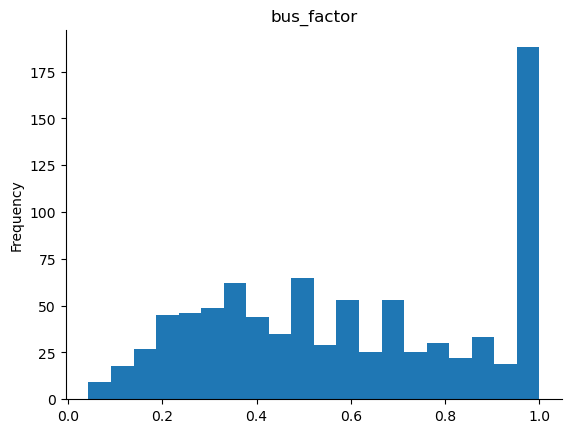

In [6]:
from matplotlib import pyplot as plt
df['bus_factor'].plot(kind='hist', bins=20, title='bus_factor')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
df['bus_factor'].describe()

count    877.000000
mean       0.598275
std        0.289227
min        0.043478
25%        0.346154
50%        0.577720
75%        0.888889
max        1.000000
Name: bus_factor, dtype: float64

In [8]:
df.loc['Open Source Observer']

num_contributors                     17.000000
all_contributions                   496.000000
contributions_by_top_contributor    177.000000
bus_factor                            0.356855
Name: Open Source Observer, dtype: float64

In [9]:
df.loc['Protocol Guild']

num_contributors                     645.000000
all_contributions                   3684.000000
contributions_by_top_contributor     199.000000
bus_factor                             0.054017
Name: Protocol Guild, dtype: float64